# ISODATA course work 5th semester 

# вариант 1

## algorithm ISODATA v2 (реализация по учебнику)

In [ ]:
import numpy as np
from scipy.cluster import vq

import matplotlib.pyplot as plt
# вывод графика
# добавить если dim>2, то выводить как 2^DIM графиков
def isodata_plot_v2(img, params = 0, class_image = 0):
  if (params == 0):
    fig = plt.figure()

    dataset_size = img.shape[0]
    dim = img.shape[1]
    # print(dataset_size)

    colors = ['g', 'r', 'c', 'goldenrod', 'b', 'm', 'y', 'k', 'aqua', 'saddlebrown']

    temp_x = []
    temp_y = []
    for j in range(dataset_size):
      temp_x.append(img[j][0])
      temp_y.append(img[j][1])

    plt.scatter(temp_x, temp_y, marker = 'o', alpha=0.5, 
                edgecolors='k', s=150)

    plt.title(f"before ISODATA dim = {dim}")
    plt.xlabel('x')                
    plt.ylabel('y')

    fig.set_size_inches((15,15))
    plt.show()
  else:
    fig = plt.figure()

    dataset_size = img.shape[0]
    dim = img.shape[1]
    output_size = params.get("K")
    # print(dataset_size)

    colors = ['g', 'r', 'c', 'goldenrod', 'b', 'm', 'y', 'k', 'aqua', 'saddlebrown']

    # все отмеченные кластеры
    for i in range(0, output_size):
      temp_x = []
      temp_y = []
      for j in range(dataset_size):
        if (class_image[j] == i):
          temp_x.append(img[j][0])
          temp_y.append(img[j][1])

      plt.scatter(temp_x, temp_y, color=colors[i], marker = 'o', alpha=0.5, 
                  edgecolors='k', label=' '+str(i), s=150)

    i = -1
    temp_x = []
    temp_y = []
    for j in range(dataset_size):
      if (class_image[j] == i):
        temp_x.append(img[j][0])
        temp_y.append(img[j][1])

    plt.scatter(temp_x, temp_y, color='white', marker = 'o', alpha=0.1, 
                edgecolors='k', label=' '+str(i), s=270)

    plt.title(f"ISODATA dim = {dim}")
    plt.xlabel('x')                
    plt.ylabel('y')
    plt.legend(loc='lower right')

    fig.set_size_inches((15,15))
    plt.show()

# установка начальных параметров, если не заданы пользователем
def initialize_parameters(parameters=None):
    # пустой словарь, заполняем дефолтными параметрами, 
    # если пользователь не задал
    parameters = {} if not parameters else parameters

    def safe_pull_value(parameters, key, default):
        return parameters.get(key, default)

    # number of clusters desired
    K = safe_pull_value(parameters, 'K', 5)

    # maximum number of iterations
    I = safe_pull_value(parameters, 'I', 100)

    # maximum of number of pairs of clusters which can be merged
    P = safe_pull_value(parameters, 'P', 4)

    # threshold value for  minimum number of samples in each cluster
    # (discarding clusters)
    THETA_M = safe_pull_value(parameters, 'THETA_M', 10)

    # threshold value for standard deviation (for split)
    THETA_S = safe_pull_value(parameters, 'THETA_S', 1)
    # threshold value for pairwise distances (for merge)
    THETA_C = safe_pull_value(parameters, 'THETA_C', 20)

    # percentage of change in clusters between each iteration
    #(to stop algorithm)
    THETA_O = safe_pull_value(parameters, 'THETA_O', 0.05)

    # can use any of both fixed or random
    # number of starting clusters
    # k = np.random.randint(1, K)
    k = safe_pull_value(parameters, 'k', K)

    ret = locals()
    ret.pop('safe_pull_value')
    ret.pop('parameters')
    globals().update(ret)


# true - остановить алгоритм, тк мало изменений в кластерах
def quit_low_change_in_clusters0(centers, last_centers, iter):
    quit = False
    if centers.shape == last_centers.shape:
        thresholds = np.abs((centers - last_centers) / (last_centers + 1))
        #print(centers)

        if np.all(thresholds <= THETA_O):  # percent of change in [0:1]
            quit = True

    return quit

# объединение кластеров по проходному барьеру
def merge_clusters0(img_class_flat, centers, clusters_list):
    pair_dists = compute_pairwise_distances(centers)

    first_p_elements = pair_dists[:P]

    below_threshold = [(c1, c2) for d, (c1, c2) in first_p_elements
                                if d < THETA_C]

    if below_threshold:
        k = centers.size
        count_per_cluster = np.zeros(k)
        to_add = np.array([])  # new clusters to add
        to_delete = np.array([])  # clusters to delete

        for cluster in range(0, k):
            result = np.where(img_class_flat == clusters_list[cluster])
            indices = result[0]
            count_per_cluster[cluster] = indices.size

        for c1, c2 in below_threshold:
            c1_count = float(count_per_cluster[c1]) + 1
            c2_count = float(count_per_cluster[c2])
            factor = 1.0 / (c1_count + c2_count)
            weight_c1 = c1_count * centers[c1]
            weight_c2 = c2_count * centers[c2]

            value = round(factor * (weight_c1 + weight_c2))

            to_add = np.append(to_add, value)
            to_delete = np.append(to_delete, [c1, c2])

        #delete old clusters and their indices from the availables array
        centers = np.delete(centers, to_delete)
        clusters_list = np.delete(clusters_list, to_delete)

        #generate new indices for the new clusters
        #starting from the max index 'to_add.size' times
        start = int(clusters_list.max())
        end = to_add.size + start

        centers = np.append(centers, to_add)
        clusters_list = np.append(clusters_list, range(start, end))

        centers, clusters_list = sort_arrays_by_first(centers, clusters_list)

    return centers, clusters_list

# вычисление расстояний папарных кластеров
def compute_pairwise_distances0(centers):
    pair_dists = []
    size = centers.size

    for i in range(0, size):
        for j in range(0, size):
            if i > j:
                d = np.abs(centers[i] - centers[j])
                pair_dists.append((d, (i, j)))

    #return it sorted on the first elem
    return sorted(pair_dists)



# просчет расстояний
def compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                             clusters_list):
    k = avg_dists_to_clusters.size
    total = img_class_flat.size
    count_per_cluster = np.zeros(k)

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size

    d = ((count_per_cluster / total) * avg_dists_to_clusters).sum()

    return d

# просчет средних расстояний
def compute_avg_distance(img_flat, img_class_flat, centers, clusters_list):
    k = centers.size
    avg_dists_to_clusters = np.array([])

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]

        total_per_cluster = indices.size + 1
        sum_per_cluster = (np.abs(img_flat[indices] - centers[cluster])).sum()

        dj = (sum_per_cluster / float(total_per_cluster))

        avg_dists_to_clusters = np.append(avg_dists_to_clusters, dj)

    return avg_dists_to_clusters


# удаление кластеров по проходному барьеру
def discard_clusters(img_class_flat, centers, clusters_list):
    k = centers.shape[0]
    to_delete = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        total_per_cluster = indices.size
        if total_per_cluster <= THETA_M:
            to_delete = np.append(to_delete, cluster)

    if to_delete.size:
        new_centers = np.delete(centers, to_delete)
        new_clusters_list = np.delete(clusters_list, to_delete)
    else:
        new_centers = centers
        new_clusters_list = clusters_list

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

#        shape_bef = centers.shape[0]
#        shape_aft = new_centers.shape[0]
#        print "Isodata(info): Discarded %s clusters." % (shape_bef - shape_aft)

#        if to_delete.size:
#            print "Clusters discarded %s" % to_delete

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    return new_centers, new_clusters_list

# обновление кластеров
def update_clusters(img_flat, img_class_flat, centers, clusters_list):
    k = centers.shape[0]
    new_centers = np.array([])
    new_clusters_list = np.array([])
    # print(img_flat)
    # print(img_class_flat)
    # print(centers)
    # print(clusters_list)

    assert centers.size == clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        #get whole cluster
        cluster_values = img_flat[indices]
        #sum and count the values
        sum_per_cluster = cluster_values.sum()
        total_per_cluster = (cluster_values.size) + 1
        #compute the new center of the cluster
        new_cluster = sum_per_cluster / total_per_cluster

        new_centers = np.append(new_centers, new_cluster)
        new_clusters_list = np.append(new_clusters_list, cluster)

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    return new_centers, new_clusters_list

# инициализация кластеров
def initial_clusters(img_flat, N, DIM, k, method="linspace"):
    # methods_availables = ["linspace", "random"]

    # assert method in methods_availables, "ERROR: method %s is no valid." \
    #                                      "Methods availables %s" \
    #                                      % (method, methods_availables)

    centers = []

    min_max = [0, 0]
    img0 = img[0]
    dim_min_max = []
    for i in range(DIM):
      dim_min_max.append(list((img0[i], img0[i])))

    for i in range(N):
      for j in range(DIM):
        if (img[i][j] < dim_min_max[j][0]):
          dim_min_max[j][0] = img[i][j]
        if (img[i][j] > dim_min_max[j][1]):
          dim_min_max[j][1] = img[i][j]


    centers = [[0] * DIM for i in range(k)]
    for i in range(DIM):
      centers0 = np.linspace(dim_min_max[i][0], dim_min_max[i][1], k)
      for j in range(k):
        centers[j][i] = centers0[j]
    #print(centers)

    # if method == "linspace":

    #     for i in range(N):


    #     max, min = img_flat.max(), img_flat.min()
    #     centers = np.linspace(min, max, k)
    # elif method == "random":
    #     start, end = 0, img_flat.size
    #     indices = np.random.randint(start, end, k)
    #     centers = img_flat.take(indices)

    return centers

def norm_Euclidean(x, y):
  z = x-y
  sum = 0
  for elem in z:
    sum += elem**2

  return (sum)**0.5

# распределение по кластерам
# шаг 2
def choose_clusters(img, centers):
  #img_class = [] # N*1
  #centers = [] # k*DIM

  img_class = []
  img_class_index = []
  for i in range(k):
    img_class_index.append([])

  for j in range(N):
    i_best = 0
    for i in range(k):
      if (norm_Euclidean(centers[i], img[j]) < norm_Euclidean(centers[i_best], img[j])):
        i_best = i
    img_class.append(i_best)

  for i in range(N):
    img_class_index[img_class[i]].append(i) 

  N_j = [0 for _ in range(k)]
  for i in range(k):
    temp = len(img_class_index[i])
    N_j[i] = temp

  return img_class, img_class_index, N_j


# шаг 3
# удаление маленьких кластеров
def delete_clusters_less_M(img, centers, 
                           img_class, 
                           img_class_index,
                           N_j):
  global k
  i = 0
  # while (i<k):
    # if (N_j[i] < THETA_M):
    #   for elem in img_class_index[i]:
    #     img_class[elem] = -1
    #   #print(img_class)
    #   centers.pop(i)
    #   img_class_index.pop(i)
    #   N_j.pop(i)
    #   k-=1
    # else:
    #   i+=1


  return centers, img_class, img_class_index, N_j


# шаг 4
# корректировка центров
def centers_correction(img, centers, 
                           img_class, 
                           img_class_index,
                           N_j):
  global k

  #print(sum)
  for i in range(k):
    sum0 = [0 for _ in range(DIM)]
    for j in range(N_j[i]):
      sum0 += img[img_class_index[i][j]]
    #print(sum0)
    if (N_j[i] != 0):
      sum0 = sum0 / N_j[i]
    centers[i] = sum0

  return centers, img_class, img_class_index, N_j

  
# шаг 5
# среднее расстояние D_j
def Calculation_D_j(img, centers, 
                    img_class, 
                    img_class_index,
                    N_j,
                    D_j):
  global k


  D_j = [0 for _ in range(k)]
  for i in range(k):
    sum = 0
    for j in range(N_j[i]):
      sum += norm_Euclidean(centers[i], img[img_class_index[i][j]])
    if (N_j[i] != 0):
      sum/=N_j[i]
    D_j[i] = sum

  #print("D_j:", D_j)
  return centers, img_class, img_class_index, N_j, D_j


  
# шаг 6
# обобщенное расстояние D_all
def Calculation_D_all(img, centers, 
                    img_class, 
                    img_class_index,
                    N_j,
                    D_j, D_all):
  global k


  D_all = 0
  sum = 0
  for i in range(k):
    sum += D_j[i]*N_j[i]
    sum/=N
    D_all = sum

  #print("D_all:", D_all)
  return centers, img_class, img_class_index, N_j, D_j, D_all


# шаг 8
# вычисляется вектор среднеквадратичноrо отклонения  sigma_j
def calculation_sigma_j(img, 
                        centers, 
                        img_class, 
                        img_class_index,
                        N_j):
  global k

  sigma_j = np.zeros((k, DIM))
  for j in range(k):
    for i in range(DIM):
      sum = 0
      for k1 in range(N_j[j]):
        #print(centers[j][i])
        sum += (img[img_class_index[j][k1]][i]-centers[j][i])**2
      if (N_j[j] != 0):
        sum/=N_j[j]
      sum = sum**0.5
      sigma_j[j][i] = sum

  return centers, img_class, img_class_index, N_j, sigma_j


# шаг 9
# вычисляется вектор среднеквадратичноrо отклонения sigma_j
def calculation_sigma_j_max(sigma_j):
  global k

  sigma_j_max = np.zeros(k)
  for j in range(k):
    sigma_j_max[j] = max(sigma_j[j])

  return sigma_j_max

# шаг 10
# расщепление кластеров
def split_clusters(img, 
                  centers, 
                  img_class, 
                  img_class_index,
                  N_j, D_j, D_all,
                  sigma_j, sigma_j_max):


  # print("img:", img)  
  # print("img_class:", img_class)
  # print("centers:", centers)
  # print("img_class_index:", img_class_index)
  # print("N_j:", N_j)
  # print("D_j:", D_j)
  # print("D_all:", D_all)
  # print("sigma_j:", sigma_j)
  # print("sigma_j_max:", sigma_j_max)

  global k

  flag_sigma = 0
  for elem in sigma_j_max:
    if (elem <= THETA_S):
      flag_sigma = 1

  #print(flag_sigma)

  if (flag_sigma == 1):
    return centers, img_class, img_class_index, \
      N_j, D_j, D_all, sigma_j, sigma_j_max  

  last_k = k
  # для каждого j из k и расщиплят много можно пока k <= K//2

  # if (iter % 2) and (k < 2*K):
  #   a = 1

  # sigma_j = np.zeros((k, DIM))
  # for j in range(k):
  #   for i in range(DIM):
  #     sum = 0
  #     for k1 in range(N_j[j]):
  #       #print(centers[j][i])
  #       sum += (img[img_class_index[j][k1]][i]-centers[j][i])**2
  #     sum/=N_j[j]
  #     sum = sum**0.5
  #     sigma_j[j][i] = sum




  #   delta = 10
  #   k = centers.size
  #   count_per_cluster = np.zeros(k)
  #   stddev = np.array([])

  #   avg_dists_to_clusters = compute_avg_distance(img_flat, img_class_flat,
  #                                                centers, clusters_list)
  #   d = compute_overall_distance(img_class_flat, avg_dists_to_clusters,
  #                                clusters_list)

  #   # compute all the standard deviation of the clusters
  #   for cluster in range(0, k):
  #       indices = np.where(img_class_flat == clusters_list[cluster])[0]
  #       count_per_cluster[cluster] = indices.size
  #       value = ((img_flat[indices] - centers[cluster]) ** 2).sum()
  #       value /= count_per_cluster[cluster]
  #       value = np.sqrt(value)
  #       stddev = np.append(stddev, value)

  #   cluster = stddev.argmax()
  #   max_stddev = stddev[cluster]
  #   max_clusters_list = int(clusters_list.max())

  #   if max_stddev > THETA_S:
  #       if avg_dists_to_clusters[cluster] >= d:
  #           if count_per_cluster[cluster] > (2.0 * THETA_M):
  #               old_cluster = centers[cluster]
  #               new_cluster_1 = old_cluster + delta
  #               new_cluster_2 = old_cluster - delta

  #               centers = np.delete(centers, cluster)
  #               clusters_list = np.delete(clusters_list, cluster)

  #               centers = np.append(centers, [new_cluster_1, new_cluster_2])
  #               clusters_list = np.append(clusters_list, [max_clusters_list,
  #                                         (max_clusters_list + 1)])

  #               centers, clusters_list = sort_arrays_by_first(centers,
  #                                                             clusters_list)

  #               assert centers.size == clusters_list.size, \
  #                  "ERROR: split() centers and clusters_list size are different"

  return centers, img_class, img_class_index, \
    N_j, D_j, D_all, sigma_j, sigma_j_max

# шаг 11
# вычисление попарных расстояний
def centers_distance(centers):
  D_ij = np.zeros((k, k))


  return centers, D_ij


# сортировка кластеров 11 этап
def sort_arrays_by_first(centers, clusters_list):
    assert centers.size == clusters_list.size, \
    "ERROR: sort_arrays_by_first centers and clusters_list size are not equal"

    indices = np.argsort(centers)

    sorted_centers = centers[indices]
    sorted_clusters_list = clusters_list[indices]

    return sorted_centers, sorted_clusters_list

# main ISODATA algorithm
def isodata_classification_v2(img, parameters=None, flag_all_images = True,
                              debug = True):
    global K, I, P, THETA_M, THETA_S, THEHTA_C, THETA_O, k
    global N, DIM, N_j
    initialize_parameters(parameters)

    # N - количество образов
    # DIM - размерность образов
    N, DIM = img.shape  # for reshaping at the end

    clusters_list = np.arange(k)  # number of clusters availables
    
    centers = [] # k*DIM
    if (debug):
      print(f"Isodata(info): Запуск алгоритма с {k} кластерами")
    centers = initial_clusters(img, N, DIM, k, "linspace")

    for iter in range(0, I):
        #print(k)
        # img # N*DIM
        # centers = [] # k*DIM
        img_class = [] # N*1, -1 значит точка без класса
        img_class_index = [] # k*(1<->DIM) индексы элементов вход в k классов
        D_j = [] # k*1
        D_all = [] # 1*1
        sigma_j = None

        if (debug):
          print(f"Isodata(info): Итерация: {iter} Кол-во кластеров: {k}")
        last_centers = centers.copy()
        # assing each of the samples to the closest cluster center

        last_k = k

        # шаг 2
        # img_class - список принадлежности образов кластерам
        img_class, img_class_index, N_j = choose_clusters(img, centers)

        # шаг 3
        # удаление
        centers, img_class, img_class_index, N_j = delete_clusters_less_M(img, 
                                                            centers, 
                                                            img_class, 
                                                            img_class_index,
                                                            N_j)
        
        # шаг 4
        # корректировка центров
        centers, img_class, img_class_index, N_j = centers_correction(img, 
                                                            centers, 
                                                            img_class, 
                                                            img_class_index,
                                                            N_j)

        # шаг 5
        # среднее расстояние D_j
        centers, img_class, img_class_index, N_j, D_j = Calculation_D_j(img, 
                                                            centers, 
                                                            img_class, 
                                                            img_class_index,
                                                            N_j, D_j)

        # шаг 6
        # обобщенное расстояние D_all
        centers, img_class, img_class_index, N_j, D_j, D_all = Calculation_D_all(img, 
                                                            centers, 
                                                            img_class, 
                                                            img_class_index,
                                                            N_j, D_j, D_all)

        # шаг 7
        if (iter % 2) and (k < 2*K) and (iter != I-1):
          # шаг 8
          # вычисляется вектор среднеквадратичноrо отклонения  sigma_j
          centers, img_class, img_class_index, N_j, sigma_j = calculation_sigma_j(img, 
                                                              centers, 
                                                              img_class, 
                                                              img_class_index,
                                                              N_j)
          
          #print("sigma_j:", sigma_j)

          # шаг 9
          # вычисляется maх компонента вектора среднеквадратичноrо отклонения  sigma_j
          sigma_j_max = calculation_sigma_j_max(sigma_j)
          #print("sigma_j_max:", sigma_j_max)


          # шаг 10
          # расщепление кластеров

          centers, img_class, img_class_index, \
          N_j, D_j, D_all, sigma_j, sigma_j_max = split_clusters(img, 
                                                          centers, 
                                                          img_class, 
                                                          img_class_index,
                                                          N_j, D_j, D_all,
                                                          sigma_j, sigma_j_max)



        else:
          THETA_C = 0


        if (k != last_k): # к шагу 2
          continue

        # шаг 11
        # вычисление попарных расстояний
        centers, D_ij = centers_distance(centers)





                            

#         centers, clusters_list = discard_clusters(img_class_flat,
#                                                   centers, clusters_list)
#         centers, clusters_list = update_clusters(img_flat,
#                                                  img_class_flat,
#                                                  centers, clusters_list)
#         k = centers.size

#         if k <= (K / 2.0):  # too few clusters => split clusters
#             centers, clusters_list = split_clusters(img_flat, img_class_flat,
#                                                     centers, clusters_list)

#         elif k > (K * 2.0):  # too many clusters => merge clusters
#             centers, clusters_list = merge_clusters(img_class_flat, centers,
#                                                     clusters_list)
#         else:  # nor split or merge are needed
#             pass

#         k = centers.size
# ###############################################################################
#         if quit_low_change_in_clusters(centers, last_centers, iter):
#             break
# ###############################################################################
#     print(f"Isodata(info): Завершено с {k} кластерами")
#     print(f"Isodata(info): Кол-во итераций: {iter + 1}")

#     return img_class_flat.reshape(N, M), centers, img_class_flat
    #print(clusters_list)
    #print(k)

    flag_all_images = False
    # распределить те точки, которые без кластеров (-1)
    if (flag_all_images):
      img_class, img_class_index, N_j = choose_clusters(img, centers)

    return img_class, centers, img_class_index

Isodata(info): Запуск алгоритма с 3 кластерами
0 [[0.0, 0.0], [3.0, 2.5], [6.0, 5.0]]
Isodata(info): Итерация: 0 Кол-во кластеров: 3
1 [array([0.5, 0.5]), array([3.75, 3.  ])]
Isodata(info): Итерация: 1 Кол-во кластеров: 2
2 [array([0.5, 0.5]), array([4.33333333, 3.5       ])]
Isodata(info): Итерация: 2 Кол-во кластеров: 2
img_class: [0, 0, 0, 0, 1, 1, 1, 1, 1]
centers: [array([0.875, 0.875]), array([4.8, 3.8])]
img_class_index: [[0, 1, 2, 3], [4, 5, 6, 7, 8]]


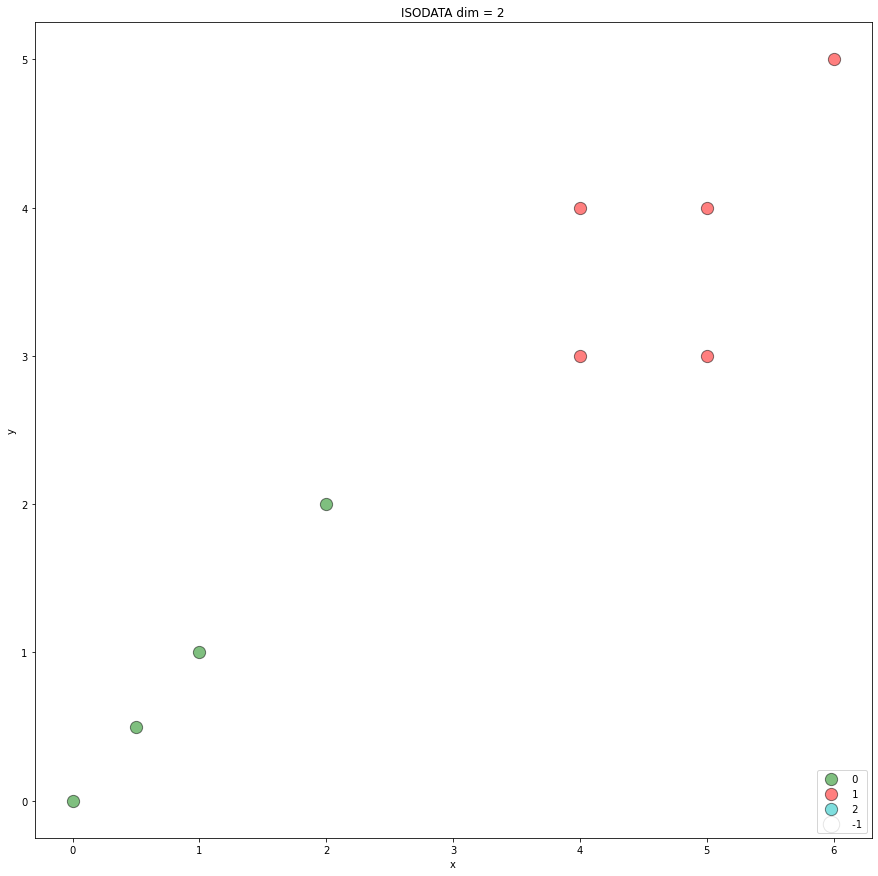

In [ ]:
# K - необходимое (желаемое) число кластеров
# THETA_M(THETA_N) - минимальное количество образов в 1м кластере
# THETA_S - параметр, характеризующий среднеквадратичное отклонение
# THETA_C - параметр, характеризующий компактность
# I - максимальное количество итераций
# P(L) - максимальное количество кластеров, которые можно объединить за 1 раз
# THETA_O - eps-изменение для продолжения алгоритма


# доделать
# 0) где-то не обнулил переменные глобально обнулить перед каждой итерацией

# 1) в конце точки без кластера присоединить к ближайшему кластеру 
# или оставить обособленными, не забывать их вывести красными квадратами на поле

# 
# 

import numpy as np

img_list_dim2 = [[0, 0], [0.5, 0.5], [1, 1], [2, 2], [4, 3], [4, 4], [5, 3], [5, 4], [6, 5]]
img = np.array(img_list_dim2)
img.shape
params = {"K": 3, "I" : 3, "P" : 2, "THETA_M" : 3, "THETA_S" : 0.1,
          "THETA_C" : 2, "THETA_O" : 0.01}
img_class, centers, img_class_index = isodata_classification_v2(img, parameters=params)

print("img_class:", img_class)
print("centers:", centers)
print("img_class_index:", img_class_index)

isodata_plot_v2(img, params, img_class)

## Функция графика и точности

In [ ]:
import matplotlib.pyplot as plt
# вывод графика
def isodata_plot(img, params = 0, class_image = 0, class_by_dim = 0):
  if (params == 0):
    fig = plt.figure()

    dataset_size = img.shape[0]
    dim = img.shape[1]
    # print(dataset_size)

    colors = ['g', 'r', 'c', 'goldenrod', 'b', 'm', 'y', 'k', 'aqua', 'saddlebrown']

    temp_x = []
    temp_y = []
    for j in range(dataset_size):
      temp_x.append(img[j][0])
      temp_y.append(img[j][1])

    plt.scatter(temp_x, temp_y, marker = 'o', alpha=0.5, 
                edgecolors='k', s=150)

    plt.title(f"before ISODATA dim = {dim}")
    plt.xlabel('x')                
    plt.ylabel('y')

    fig.set_size_inches((15,15))
    plt.show()
  else:
    fig = plt.figure()

    dataset_size = img.shape[0]
    dim = img.shape[1]
    output_size = params.get("K")
    # print(dataset_size)

    colors = ['g', 'r', 'c', 'goldenrod', 'b', 'm', 'y', 'k', 'aqua', 'saddlebrown']

    for i in range(0, output_size):
      temp_x = []
      temp_y = []
      for j in range(dataset_size):
        if (class_image[j][class_by_dim] == i):
          temp_x.append(img[j][0])
          temp_y.append(img[j][1])

      plt.scatter(temp_x, temp_y, color=colors[i], marker = 'o', alpha=0.5, 
                  edgecolors='k', label=' '+str(i), s=150)

    plt.title(f"ISODATA dim = {dim}")
    plt.xlabel('x')                
    plt.ylabel('y')
    plt.legend(loc='lower right')

    fig.set_size_inches((15,15))
    plt.show()

In [ ]:
def accuracy_v2(y_to_test, y_true):
  len1 = len(y_true)
  count = 0
  for i in range(len1):
    if (y_true[i] == y_to_test[i]):
      count+=1

  accur = count/len1*100
  print("Accuracy = {0:.2f}".format(accur))

## v2 test

### пример из книги, 8 точек


 Генерация примера и вычисление алгоритма 

In [ ]:
# пример из книги
# генерация образа (двумерного)
img_list_dim2 = [[0, 0], [0.5, 0.5], [1, 1], [2, 2], [4, 3], [4, 4], [5, 3], [5, 4], [6, 5]]
img = np.array(img_list_dim2)
img.shape

(9, 2)

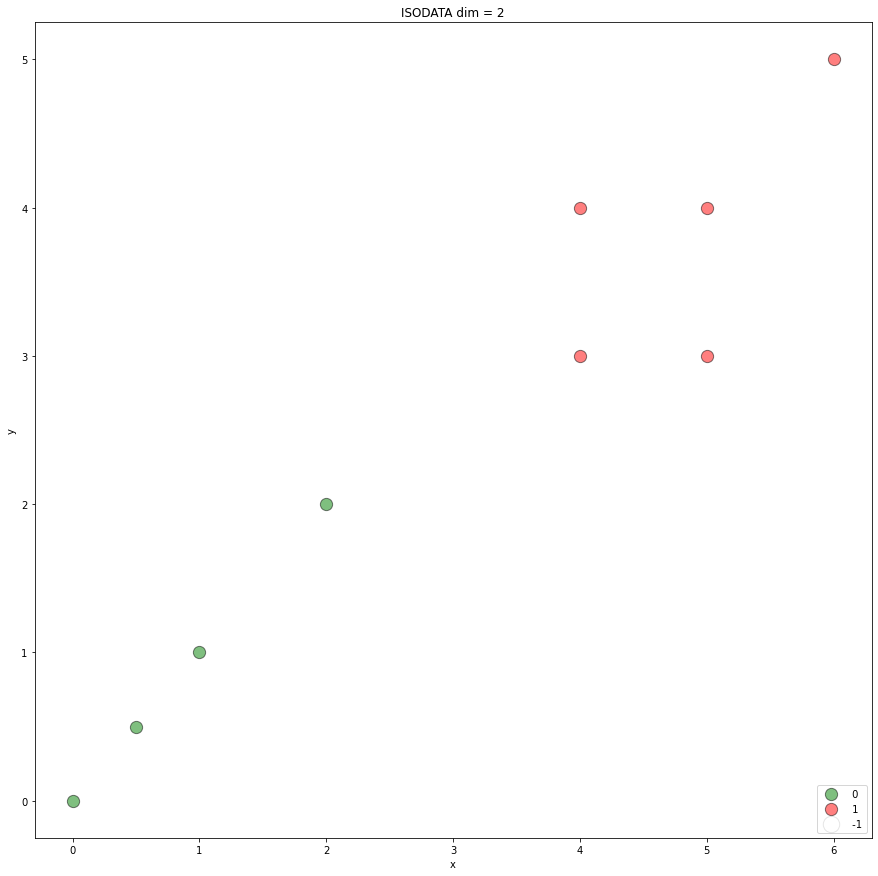

In [ ]:
# K - необходимое (желаемое) число кластеров
# THETA_M(THETA_N) - минимальное количество образов в 1м кластере
# THETA_S - параметр, характеризующий среднеквадратичное отклонение
# THETA_C - параметр, характеризующий компактность
# I - максимальное количество итераций
# P(L) - максимальное количество кластеров, которые можно объединить за 1 раз
# THETA_O - eps-изменение для продолжения алгоритма

params = {"K": 2, "I" : 100, "P" : 2, "THETA_M" : 2, "THETA_S" : 0.1,
          "THETA_C" : 2, "THETA_O" : 0.01}

# run ISODATA
img_class, centers, img_class_index = isodata_classification_v2(img, parameters=params, debug=False)

# print("img_class:", img_class)
# print("centers:", centers)
# print("img_class_index:", img_class_index)

isodata_plot_v2(img, params, img_class)

### рандомные 3 прямоугольника пересекающихся


 Генерация примера и вычисление алгоритма 

In [ ]:
import random
from datetime import datetime
random.seed(datetime.now())

def rand_rectangle(res, nums_in_one_fig, x_left, y_left, x_right, y_right):
  # x_mult = x_right-x_left
  # y_mult = y_right - y_left 
  rand_point = [0, 0]
  for i in range(nums_in_one_fig):
    rand_x = random.uniform(x_left, x_right)
    rand_y = random.uniform(y_left, y_right)

    # rand_x = x_left + x_mult*rand_one_x
    # rand_y = y_left + y_mult*rand_one_y
    # rand_point[0] = rand_x
    # rand_point[1] = rand_y
    res.append((rand_x, rand_y))
    # print(i)
  
  return res

In [ ]:
import numpy as np
#random
nums_in_one_fig = 400

img_list_dim2 = []

img_list_dim2 = rand_rectangle(img_list_dim2, nums_in_one_fig, 1, 1, 6, 5)
img_list_dim2 = rand_rectangle(img_list_dim2, nums_in_one_fig, 5, 4, 9, 9)
img_list_dim2 = rand_rectangle(img_list_dim2, nums_in_one_fig, 10, 10, 12, 12)
img = np.array(img_list_dim2)
#img.shape

#isodata_plot(img)

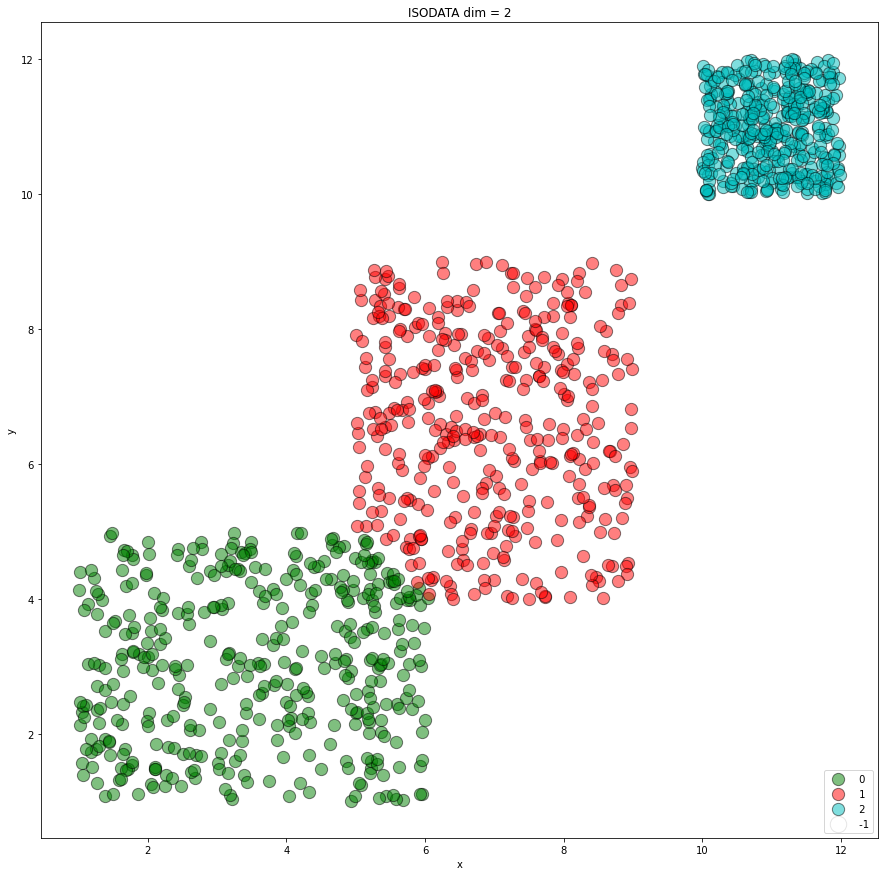

In [ ]:
# K - необходимое (желаемое) число кластеров
# I - максимальное количество итераций
# P(L) - максимальное количество кластеров, которые можно объединить за 1 раз
# THETA_M(THETA_N) - минимальное количество образов в 1м кластере
# THETA_S - параметр, характеризующий среднеквадратичное отклонение
# THETA_C - параметр, характеризующий компактность
# THETA_O - eps-изменение для продолжения алгоритма

params = {"K": 3, "I" : 100, "P" : 2, "THETA_M" : 2, "THETA_S" : 0.1,
          "THETA_C" : 2, "THETA_O" : 0.001}

# run ISODATA
img_class, centers, img_class_index = isodata_classification_v2(img, parameters=params, debug=False)

# print("img_class:", img_class)
# print("centers:", centers)
# print("img_class_index:", img_class_index)

isodata_plot_v2(img, params, img_class)


## 4) Dataset: IRIS

### Isodata

This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray

The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

In [ ]:
# загрузка датасета
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()

In [ ]:
X = iris.data
y = iris.target

img = np.array(X)

In [ ]:
print(X[0])
print(y[0])

[5.1 3.5 1.4 0.2]
0


In [ ]:
# K - необходимое (желаемое) число кластеров
# I - максимальное количество итераций
# P(L) - максимальное количество кластеров, которые можно объединить за 1 раз
# THETA_M(THETA_N) - минимальное количество образов в 1м кластере
# THETA_S - параметр, характеризующий среднеквадратичное отклонение
# THETA_C - параметр, характеризующий компактность
# THETA_O - eps-изменение для продолжения алгоритма

params = {"K": 3, "I" : 100, "P" : 2, "THETA_M" : 2, "THETA_S" : 0.1,
          "THETA_C" : 2, "THETA_O" : 0.001}

# run ISODATA
img_class, centers, img_class_index = isodata_classification_v2(img, parameters=params, debug=False)

#isodata_plot_v2(img, params=params, class_image=img_class)


In [ ]:
print("img_class:", img_class)
print("centers:", centers)
print("img_class_index:", img_class_index)

img_class: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1]
centers: [array([5.006, 3.428, 1.462, 0.246]), array([5.9016129 , 2.7483871 , 4.39354839, 1.43387097]), array([6.85      , 3.07368421, 5.74210526, 2.07105263])]
img_class_index: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93

In [ ]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [ ]:
iris_feature = pd.DataFrame(iris.data)
iris_target = pd.DataFrame(img_class) # то что предсказала isodata
iris_feature.columns = ['sepal_length','sepal_width','petal_length','petal_width']
iris_target.columns = ['species']
iris_target['species'] = iris_target['species'].map({0:'I. setosa',1:'I. versicolor',2:'I. virginica'})
iris = pd.concat([iris_feature,iris_target],axis = 1)

Isodata


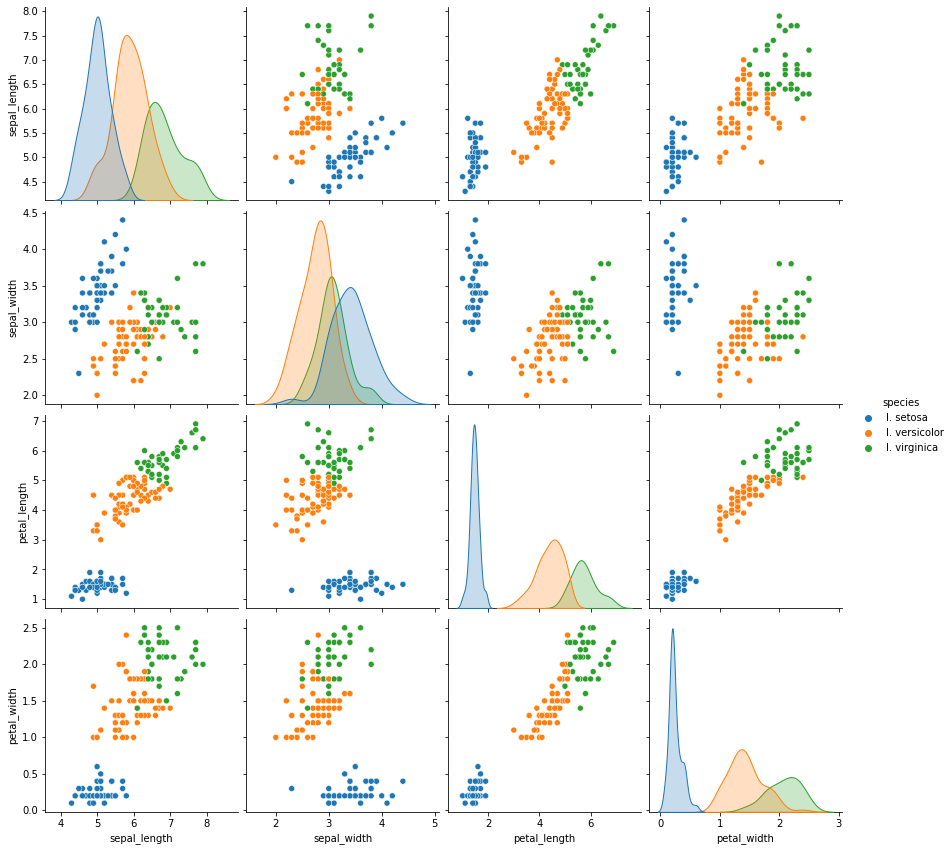

In [ ]:
print("Isodata")
sns.pairplot(iris, hue="species", height=3, diag_kind="kde")

In [ ]:
accuracy_v2(img_class, y)

Accuracy = 89.33


### Etalon

In [ ]:
iris = load_iris()
iris_feature = pd.DataFrame(iris.data)
iris_target = pd.DataFrame(iris.target) # то что предсказала isodata
iris_feature.columns = ['sepal_length','sepal_width','petal_length','petal_width']
iris_target.columns = ['species']
iris_target['species'] = iris_target['species'].map({0:'I. setosa',1:'I. versicolor',2:'I. virginica'})
iris = pd.concat([iris_feature,iris_target],axis = 1)

Etalon


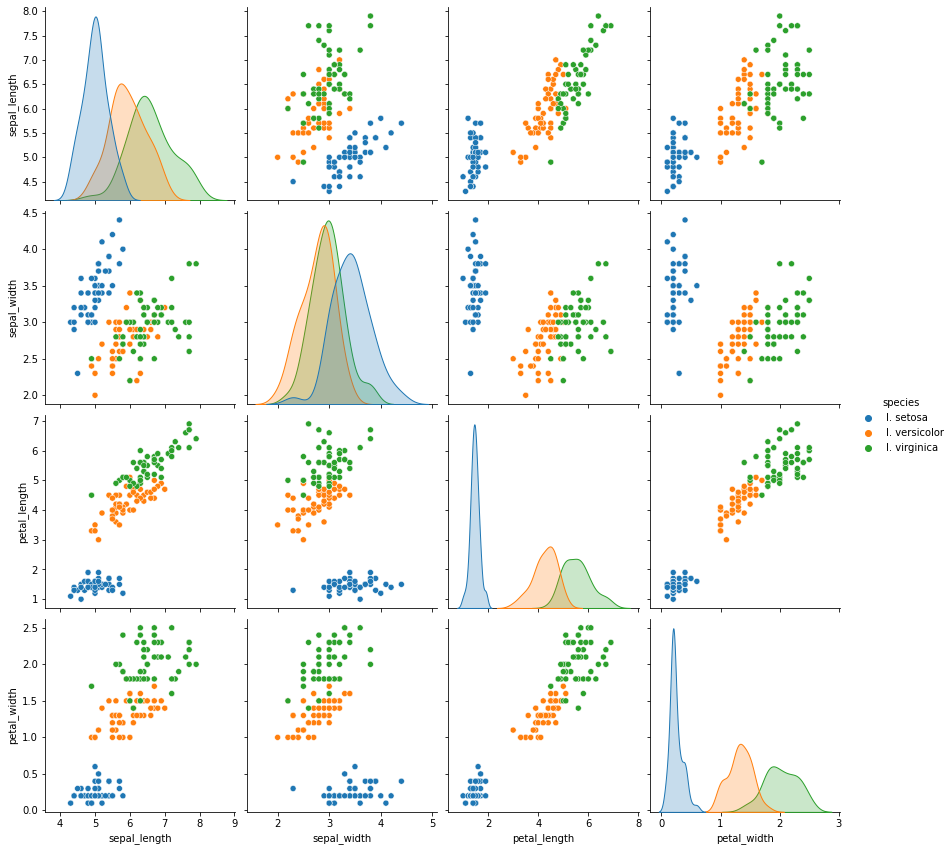

In [ ]:
print("Etalon")
sns.pairplot(iris, hue="species", height=3, diag_kind="kde")

### NN (FULLY-CONNECTED) trained on 50% DB

In [ ]:
#from tensorflow.keras.datasets import mnist     # Библиотека с базой рукописных цифр
from tensorflow.keras.models import Sequential  # Подключение класса создания модели Sequential
from tensorflow.keras.layers import Dense, Dropout       # Подключение класса Dense - полносвязный слой
from tensorflow.keras import utils              # Утилиты для подготовки данных
import numpy as np                              # Работа с массивами
import matplotlib.pyplot as plt                 # Отрисовка изображений

# Отрисовка изображений в ячейках ноутбука
%matplotlib inline 

iris = load_iris()

#(x_train_org, y_train_org), (x_test_org, y_test_org) = 

In [ ]:
from sklearn.model_selection import train_test_split
X = iris.data
y = iris.target

#x_train = np.array(X)
#y_train = np.array(y)
x_train_org, x_test_org, y_train_org, y_test_org = train_test_split(X, y, test_size=0.5)

In [ ]:


# Вывод формы данных для обучения
x_train_org.shape

# Изменение формы входных картинок с 28х28 на 784
# первая ось остается без изменения, остальные складываются в вектор
x_train = x_train_org.reshape(x_train_org.shape[0], -1)   
x_test = x_test_org.reshape(x_test_org.shape[0], -1)   

# Проверка результата
print(f'Форма обучающих данных: {x_train_org.shape} -> {x_train.shape}')
print(f'Форма  тестовых данных: {x_test_org.shape} -> {x_test.shape}')

# Нормализация входных картинок
# Преобразование x_train в тип float32 (числа с плавающей точкой) и нормализация
x_train = x_train.astype('float32') / 255.
# Преобразование x_test в тип float32 (числа с плавающей точкой) и нормализация
x_test = x_test.astype('float32') / 255.

# Задание константы количества распознаваемых классов
CLASS_COUNT = 3
# Преобразование ответов в формат one_hot_encoding
y_train = utils.to_categorical(y_train_org, CLASS_COUNT)
y_test = utils.to_categorical(y_test_org, CLASS_COUNT)
# Вывод формы y_train
# 60 тысяч примеров, каждый длины 10 по числу классов
print(y_train.shape)
# Вывод примера одного выходного вектора
print(y_train[0])
# Вывод формы массива меток
print(y_train_org.shape)
# Вывод метки, соответствующей 36-му элементу
print(y_train_org[36])

Форма обучающих данных: (75, 4) -> (75, 4)
Форма  тестовых данных: (75, 4) -> (75, 4)
(75, 3)
[1. 0. 0.]
(75,)
1


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 800)               4000      
                                                                 
 dropout_3 (Dropout)         (None, 800)               0         
                                                                 
 dense_22 (Dense)            (None, 400)               320400    
                                                                 
 dense_23 (Dense)            (None, 3)                 1203      
                                                                 
Total params: 325,603
Trainable params: 325,603
Non-trainable params: 0
_________________________________________________________________
None


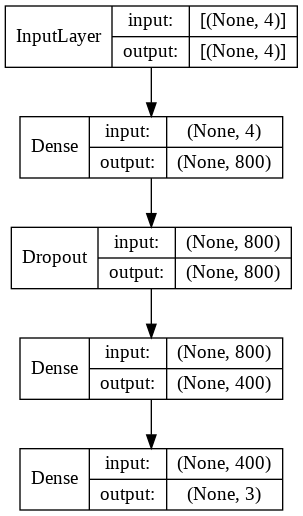

In [ ]:
input_dim = x_train_org.shape[1]
# Создание последовательной модели
model = Sequential()
# Добавление полносвязного слоя на 800 нейронов с relu-активацией
model.add(Dense(800, input_dim=input_dim, activation='relu')) 
# Добавление полносвязного слоя на 400 нейронов с relu-активацией
model.add(Dropout(0.25))
model.add(Dense(400, activation='relu')) 
# Добавление полносвязного слоя с количеством нейронов по числу классов с softmax-активацией
model.add(Dense(CLASS_COUNT, activation='softmax'))

# Компиляция модели
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Вывод структуры модели
print(model.summary())

# красивый граф модели
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
model.fit(x_train,        # обучающая выборка, входные данные
          y_train,        # обучающая выборка, выходные данные
          batch_size=15, # кол-во примеров, которое обрабатывает нейронка перед одним изменением весов
          validation_split=0.1,
          epochs=50,      # количество эпох, когда нейронка обучается на всех примерах выборки
          verbose=1)      # 0 - не визуализировать ход обучения, 1 - визуализировать


Epoch 1/50
5/5 [==============================] - 1s 110ms/step - loss: 1.0990 - accuracy: 0.3134 - val_loss: 1.0872 - val_accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 1.0963 - accuracy: 0.3731 - val_loss: 1.0934 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 1.0907 - accuracy: 0.3731 - val_loss: 1.0857 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 1.0871 - accuracy: 0.3731 - val_loss: 1.0770 - val_accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 1.0833 - accuracy: 0.3731 - val_loss: 1.0718 - val_accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 1.0824 - accuracy: 0.3731 - val_loss: 1.0627 - val_accuracy: 0.5000
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 1.0791 - accuracy: 0.3731 - val_loss: 1.0521 - val_accuracy: 0.5000
Epoch 8/50
5/5 [==========

In [ ]:
scores = model.evaluate(x_test, 
                        y_test, 
                        verbose=1
                        )

3/3 [==============================] - 0s 5ms/step - loss: 0.2781 - accuracy: 0.9333


### Вывод (сравнение Isodata и NN):
1. Точность ISODATA на IRIS 89.33%
2. Точность на тестовой выборке НС (полносвязная) на IRIS (50% DB) 93.33%

## 6) Dataset: DIGITS (8*8=64dim пространство)

### Isodata

This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray

The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

In [ ]:
# загрузка датасета
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_digits()

In [ ]:
X = iris.data
y = iris.target

img = np.array(X)

In [ ]:
print(X[0])
print(y[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
0


In [ ]:
# K - необходимое (желаемое) число кластеров
# I - максимальное количество итераций
# P(L) - максимальное количество кластеров, которые можно объединить за 1 раз
# THETA_M(THETA_N) - минимальное количество образов в 1м кластере
# THETA_S - параметр, характеризующий среднеквадратичное отклонение
# THETA_C - параметр, характеризующий компактность
# THETA_O - eps-изменение для продолжения алгоритма

params = {"K": 10, "I" : 100, "P" : 2, "THETA_M" : 2, "THETA_S" : 0.1,
          "THETA_C" : 2, "THETA_O" : 0.001}

# run ISODATA
img_class, centers, img_class_index = isodata_classification_v2(img, parameters=params, debug=False)

#isodata_plot_v2(img, params=params, class_image=img_class)


In [ ]:
print("img_class:", img_class)
print("centers:", centers)
print("img_class_index:", img_class_index)

In [ ]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [ ]:
accuracy_v2(img_class, y)

Accuracy = 70.18


### NN (FULLY-CONNECTED) trained on 50% DB

In [ ]:
#from tensorflow.keras.datasets import mnist     # Библиотека с базой рукописных цифр
from tensorflow.keras.models import Sequential  # Подключение класса создания модели Sequential
from tensorflow.keras.layers import Dense, Dropout       # Подключение класса Dense - полносвязный слой
from tensorflow.keras import utils              # Утилиты для подготовки данных
import numpy as np                              # Работа с массивами
import matplotlib.pyplot as plt                 # Отрисовка изображений

# Отрисовка изображений в ячейках ноутбука
%matplotlib inline 

iris = datasets.load_digits()

#(x_train_org, y_train_org), (x_test_org, y_test_org) = 

In [ ]:
from sklearn.model_selection import train_test_split
X = iris.data
y = iris.target

#x_train = np.array(X)
#y_train = np.array(y)
x_train_org, x_test_org, y_train_org, y_test_org = train_test_split(X, y, test_size=0.5)

In [ ]:


# Вывод формы данных для обучения
x_train_org.shape

# Изменение формы входных картинок с 28х28 на 784
# первая ось остается без изменения, остальные складываются в вектор
x_train = x_train_org.reshape(x_train_org.shape[0], -1)   
x_test = x_test_org.reshape(x_test_org.shape[0], -1)   

# Проверка результата
print(f'Форма обучающих данных: {x_train_org.shape} -> {x_train.shape}')
print(f'Форма  тестовых данных: {x_test_org.shape} -> {x_test.shape}')

# Нормализация входных картинок
# Преобразование x_train в тип float32 (числа с плавающей точкой) и нормализация
x_train = x_train.astype('float32') / 255.
# Преобразование x_test в тип float32 (числа с плавающей точкой) и нормализация
x_test = x_test.astype('float32') / 255.

# Задание константы количества распознаваемых классов
CLASS_COUNT = 10
# Преобразование ответов в формат one_hot_encoding
y_train = utils.to_categorical(y_train_org, CLASS_COUNT)
y_test = utils.to_categorical(y_test_org, CLASS_COUNT)
# Вывод формы y_train
# 60 тысяч примеров, каждый длины 10 по числу классов
print(y_train.shape)
# Вывод примера одного выходного вектора
print(y_train[0])
# Вывод формы массива меток
print(y_train_org.shape)
# Вывод метки, соответствующей 36-му элементу
print(y_train_org[36])

Форма обучающих данных: (898, 64) -> (898, 64)
Форма  тестовых данных: (899, 64) -> (899, 64)
(898, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(898,)
6


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 800)               52000     
                                                                 
 dropout_4 (Dropout)         (None, 800)               0         
                                                                 
 dense_25 (Dense)            (None, 400)               320400    
                                                                 
 dense_26 (Dense)            (None, 10)                4010      
                                                                 
Total params: 376,410
Trainable params: 376,410
Non-trainable params: 0
_________________________________________________________________
None


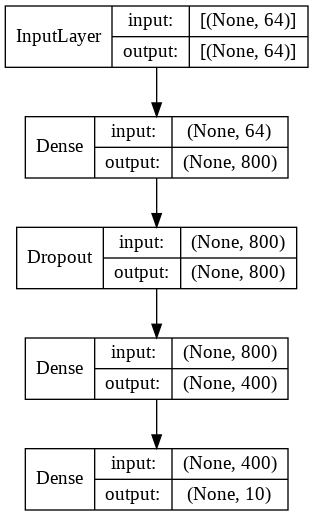

In [ ]:
input_dim = x_train_org.shape[1]
# Создание последовательной модели
model = Sequential()
# Добавление полносвязного слоя на 800 нейронов с relu-активацией
model.add(Dense(800, input_dim=input_dim, activation='relu')) 
# Добавление полносвязного слоя на 400 нейронов с relu-активацией
model.add(Dropout(0.25))
model.add(Dense(400, activation='relu')) 
# Добавление полносвязного слоя с количеством нейронов по числу классов с softmax-активацией
model.add(Dense(CLASS_COUNT, activation='softmax'))

# Компиляция модели
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Вывод структуры модели
print(model.summary())

# красивый граф модели
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
model.fit(x_train,        # обучающая выборка, входные данные
          y_train,        # обучающая выборка, выходные данные
          batch_size=32, # кол-во примеров, которое обрабатывает нейронка перед одним изменением весов
          validation_split=0.1,
          epochs=50,      # количество эпох, когда нейронка обучается на всех примерах выборки
          verbose=1)      # 0 - не визуализировать ход обучения, 1 - визуализировать


Epoch 1/50
26/26 [==============================] - 2s 40ms/step - loss: 2.1827 - accuracy: 0.4196 - val_loss: 1.9666 - val_accuracy: 0.6556
Epoch 2/50
26/26 [==============================] - 1s 19ms/step - loss: 1.5939 - accuracy: 0.6931 - val_loss: 1.2305 - val_accuracy: 0.8333
Epoch 3/50
26/26 [==============================] - 0s 13ms/step - loss: 0.9073 - accuracy: 0.8144 - val_loss: 0.6323 - val_accuracy: 0.9333
Epoch 4/50
26/26 [==============================] - 0s 12ms/step - loss: 0.5811 - accuracy: 0.8713 - val_loss: 0.4382 - val_accuracy: 0.9111
Epoch 5/50
26/26 [==============================] - 0s 14ms/step - loss: 0.4340 - accuracy: 0.8874 - val_loss: 0.3392 - val_accuracy: 0.9333
Epoch 6/50
26/26 [==============================] - 0s 13ms/step - loss: 0.3551 - accuracy: 0.9109 - val_loss: 0.3169 - val_accuracy: 0.9111
Epoch 7/50
26/26 [==============================] - 0s 13ms/step - loss: 0.3116 - accuracy: 0.9183 - val_loss: 0.2711 - val_accuracy: 0.9111
Epoch 8/50
26

In [ ]:
scores = model.evaluate(x_test, 
                        y_test, 
                        verbose=1
                        )

29/29 [==============================] - 0s 5ms/step - loss: 0.0874 - accuracy: 0.9733


### Вывод (сравнение Isodata и NN):
1. Точность ISODATA на IRIS 70.18%
2. Точность на тестовой выборке НС (полносвязная) на IRIS (50% DB) 97.33%